In [81]:
import numpy as np
import matplotlib.pyplot as plt
from math import *
import time

%matplotlib notebook

In [89]:
#some functions for calculating and plotting diagrams
def plot_rock():
    #to plot a rock in 2D
    fig, [ax1, ax2] = plt.subplots(figsize=(10, 6), ncols=2,
                              gridspec_kw={'width_ratios': [1, 2]})
    x = [-1, -1, 1, 1, -1]
    y = [-2, 2, 2, -2, -2]
    ax1.fill(x, y, 'deepskyblue')
    ax1.text(-1.5, .1, '$\sigma_3$', fontsize=20)
    ax1.text(.1, 2.3, '$\sigma_1$', fontsize=20)
    ax1.arrow(-1.6, 0, .5, 0, head_width=.05, color='k')
    ax1.arrow(0, 2.6, 0, -.5, head_width=.05, color='k')
    ax1.set_xlim(-1.8, 1.8)
    ax1.set_ylim(-2, 2.6)
    ax1.axis('off')
    ax1.set_aspect('equal')
    
    ax2.spines['left'].set_position(('data', 0))
    ax2.spines['bottom'].set_position(('data', 0))
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)
    ax2.set_aspect('equal')    
    ax2.tick_params(axis='both', labelsize=16)
    ax2.annotate('$\sigma_n$', xy=(1, .48), xycoords='axes fraction', fontsize=20)
    ax2.annotate('$\sigma_s$', xy=(.05, .98), xycoords='axes fraction', fontsize=20)
    plt.tight_layout()

    return fig, ax1, ax2


def sigma1_smaller_than_sigma3(sigma1, sigma3):
    #to make sure sigma1 >= sigma3
    if (sigma1<sigma3):
        print ('Sigma 1 cannot be smaller than Sigma 3')
        
    return (sigma1<sigma3)

def plot_fracture(ax, angle, line='-', color='k'):
    #to plot a fracture in a rock
    x0, x1 = -1, 1
    y0, y1 = -2, 2
    x = np.linspace(x0, x1, 500)
    y = x*tan(radians(angle))
    xx = x[(y>=y0) & (y<=y1)]
    yy = y[(y>=y0) & (y<=y1)]
    ax.plot(xx, yy, line, color=color, lw=2)

    
def get_p(sigma1, sigma3, theta):
    #to calculate normal and shear stress on a plane
    if sigma1_smaller_than_sigma3(sigma1, sigma3):
        return
    r = (sigma1-sigma3)*.5
    mean = .5*(sigma1+sigma3)
    sigma_n = cos(radians(2*theta))*r+mean
    sigma_s = sin(radians(2*theta))*r
    
    return sigma_n, sigma_s


def plot_fracture_on_mohr(ax, sigma1, sigma3, theta, line='-', color='r'):
    #to plot a fracture on mohr's diagram
    if sigma1_smaller_than_sigma3(sigma1, sigma3):
        return
    sigma_n, sigma_s = get_p (sigma1, sigma3, theta)
    failure_plane, = ax.plot([sigma_n, .5*(sigma1+sigma3)], [sigma_s, 0], line, color=color)
    
    return failure_plane

    
def plot_mohr(ax, sigma1, sigma3, color='grey', theta=0.):
    #to plot mohr's diagram for a stress state
    if sigma1_smaller_than_sigma3(sigma1, sigma3):
        return
    
    r = (sigma1-sigma3)*.5
    mean = .5*(sigma1+sigma3)
    x = np.linspace(sigma3, sigma1, 100)
    y = (r**2-(x-(sigma3+r))**2)**.5
    mohr_circle, = ax.plot(np.concatenate((x, x)), np.concatenate((y, -y)), '-',  color=color)
    failure_plane = plot_fracture_on_mohr(ax, sigma1, sigma3, theta, color='k')
    
    return mohr_circle, failure_plane


def plot_coulomb(ax, c=50, mu=.6, max_sigma_n=500.):
    #to plot coulomb failure envelope 
    x = np.linspace(0, max_sigma_n, 100)
    y = c + mu * x
    yy = mu * x
    ax.plot(x, y, '-', x, -y, '-', color='r')

    
def plot_byerlee(ax, mu=0.6):
    #to plot byerlee envelope 
    x = np.linspace(0, 500, 10)
    y = mu * x
    ax.plot(x, y, '-', x, -y, '-', color='b')

    
def check_byerlee(sigma_s, sigma_n, mu=0.6):
    #to check if the rock slides on a preexisting surface

    return abs(sigma_s) >= abs(sigma_n*mu)


def check_coulomb(sigma1, sigma3, c=50, mu=0.6):
    #to check if a new fracture developes in the rock
    if sigma1_smaller_than_sigma3(sigma1, sigma3):
        return
    diff_stress = sigma1-sigma3
    r = .5*diff_stress
    p = np.array([])
    for x in np.linspace(sigma3, sigma1, 100):
        if (r**2-(x-(sigma3+r))**2)**.5 >= c+mu*x:
            p = np.append(p, x)
            
    if (len(p)>0):
        inter_x = x.mean()
    else:
        inter_x = nan
            
    return inter_x

<IPython.core.display.Javascript object>


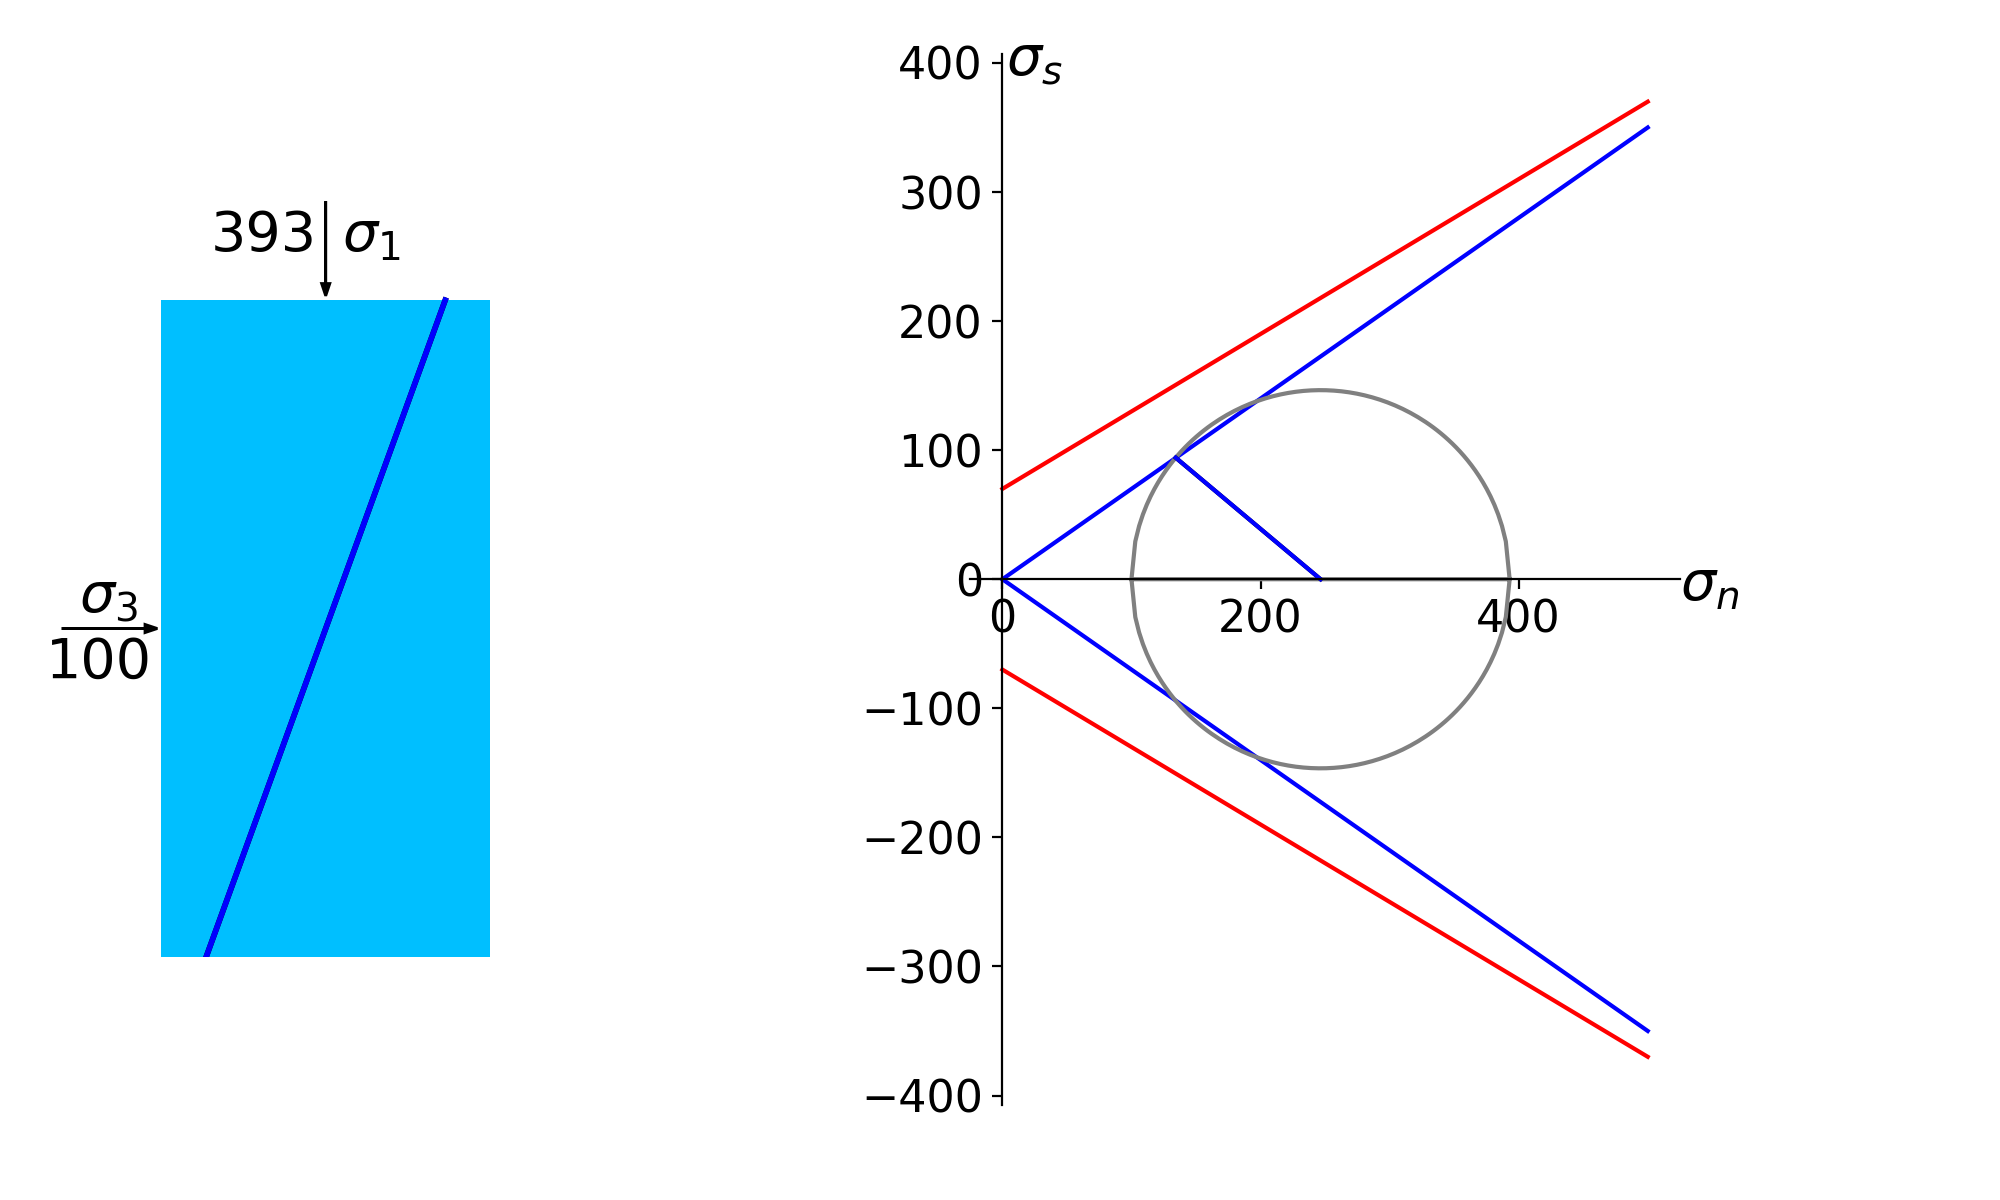

In [90]:
#to plot mohr's diagram with certain values for the parameters
c = 70      #cohesion for coulomb failure criterion
mu1 = 0.6   #internal friction coefficient for coulomb failure
mu2 = 0.7   #coefficient for frictional sliding
theta = 70  #angle of the preexisting fracture to sigma3
sigma3 = 100
sigma1_start = 150

fig, ax1, ax2 = plot_rock()
plot_fracture(ax1, theta)
plot_coulomb(ax2, c=c, mu=mu1)
plot_byerlee(ax2, mu=mu2)
mohr_circle, failure_plane = plot_mohr(ax2, sigma1_start, sigma3, theta=theta)
ax1.text(-1.7, -.3, sigma3, fontsize=20)
sigma1_number = ax1.text(-.7, 2.3, sigma1_start, fontsize=20)

In [91]:
#now sigma3 is fixed, and sigma1 is increased gradually
#and we check if the rock developes a new fracture or slides on a preexisting fracture

sigma1_maximum = 1000
for sigma1 in range(sigma1_start, sigma1_maximum, 1):
    for shp in [sigma1_number, mohr_circle, failure_plane]:
        shp.remove()
    sigma1_number = ax1.text(-.7, 2.3, str(sigma1), fontsize=20)
    mohr_circle, failure_plane = plot_mohr(ax2, sigma1, sigma3, theta=theta, color='grey')
    fig.canvas.draw()
    sigma_n, sigma_s = get_p(sigma1, sigma3, theta)
    p = check_coulomb(sigma1, sigma3, c=c, mu=mu1)
    
    if np.isfinite(p):
        fail_angle = (degrees(atan(mu1))+90)/2        
        plot_fracture(ax1, fail_angle, color='r')
        plot_fracture_on_mohr(ax2, sigma1, sigma3, fail_angle, color='r')
        time.sleep(1)
        
        plot_fracture(ax1, 180-fail_angle, line='--', color='r')
        plot_fracture_on_mohr(ax2, sigma1, sigma3, 180-fail_angle, line='--', color='r')
        break
    
    elif check_byerlee(sigma_s, sigma_n, mu=mu2):
        plot_fracture_on_mohr(ax2, sigma1, sigma3, theta, color='b')
        plot_fracture(ax1, theta, color='b')
        break

    time.sleep(.01)